# Кластеризация спектров

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale as std_scale, robust_scale

from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.pca as pca
import mlgrad.cluster as cluster
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.af as af


In [2]:
def plot_spectra(d, ax=None):
    if ax is None:
        ax = plt.gca()
    for i, key in enumerate(d):
        Xs, Ys = d[key]
        if key == '191':
            color = 'b'
            label = "B"
        if key == '606':
            color = 'r'
            label = "A"
    
        ax.plot(np.mean(Ys, axis=0), color=color, linewidth=2.0, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    ymax = mod.param.base[1:].copy()
    ymin = mod.param.base[1:].copy()
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


In [3]:
def load_data(root, scale='arith'):
    import os
    d = {}
    for fold in os.listdir(root):
        Xs = []
        Ys = []
        for fname in os.listdir(f"{root}/{fold}"):
            if not fname.endswith(".txt"):
                continue
            with open(f"{root}/{fold}/{fname}", 'rt') as h:
                xs, ys = [], []
                dys = []
                for line in h.readlines():
                    line = line.strip()
                    line = line.split()
                    line = [float(val) for val in line]
                    x = line[0]
                    y = line[1:]
                    xs.append(x)
                    ys.append(y)
                xs = np.array(xs[37:], 'd')
                ys = np.array(ys[37:], 'd')
                # xs = np.array(xs, 'd')
                # ys = np.array(ys, 'd')
                # ym = np.median(ys, axis=1)
                ys_sorted = np.sort(ys, axis=1)
                ym = np.mean(ys_sorted[:,:27], axis=1)
                ys = ym
                if scale == 'arith':
                    ys -= ys.min()
                    ys_max = ys.max()
                    # ys /= 1000
                    ys /= ys_max
                elif scale == 'mult':
                    ys_min = ys.min()
                    ys /= ys_min
                    ys -= 1
                    # ys = np.log(ys)
                elif scale == 'l1':
                    ys -= ys.min()
                    ys /= ys.sum()
                    ys *= 100
                elif scale == 'auc':
                    ys -= ys.min()
                    ys /= np.trapz(ys, xs)
                    ys *= 1000
                elif scale == 'std':
                    ys = std_scale(ys)
                    ys_min = ys.min()
                    ys -= ys_min
                elif scale == 'robust':
                    ys = robust_scale(ys)
                    ys_min = ys.min()
                    ys -= ys_min
                Xs.append(xs)
                Ys.append(ys)
        Xs, Ys =  np.array(Xs), np.array(Ys)
        
        if '191' in fold:
            d['191'] = (Xs, Ys)
        if '606' in fold:
            d['606'] = (Xs, Ys)
            
    return d

In [4]:
d = load_data("Table", scale='auc')

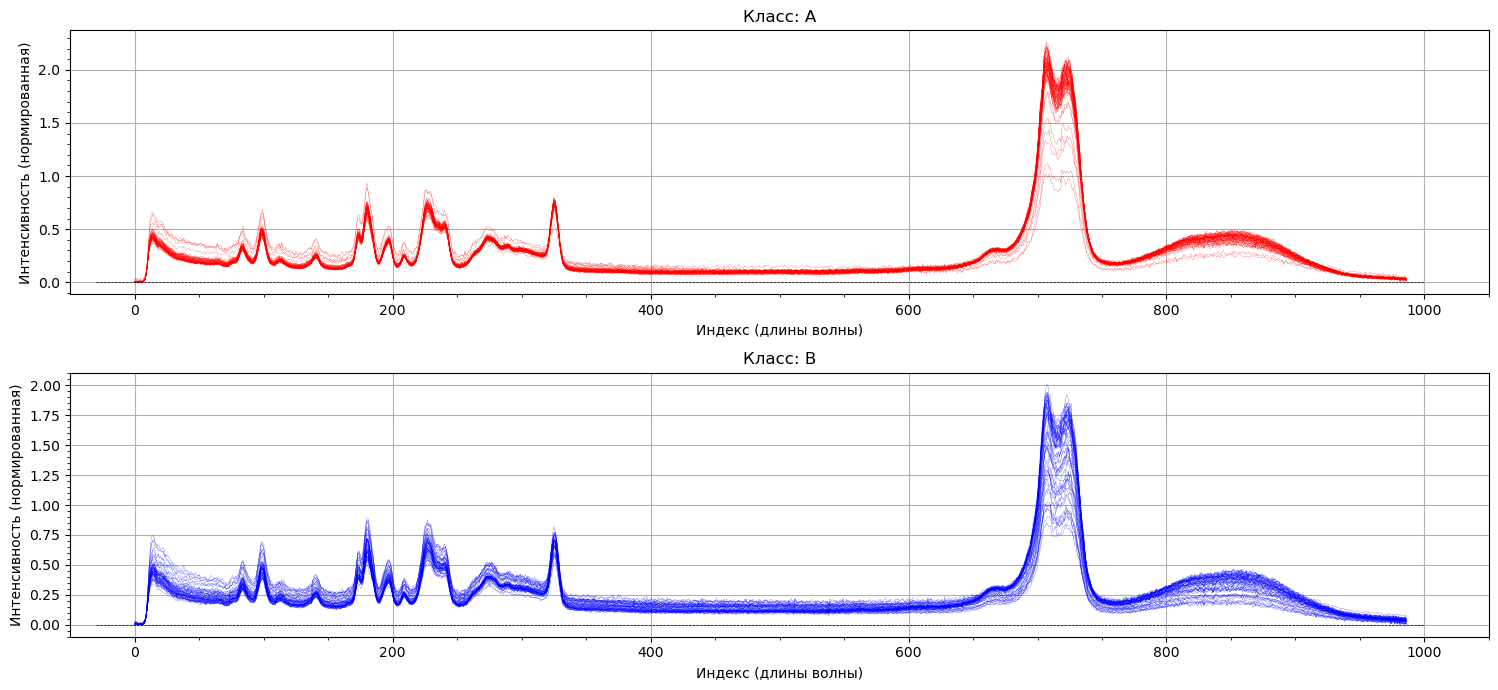

In [5]:
plt.figure(figsize=(15,7))
for i, key in enumerate(d):
    plt.subplot(2,1,i+1)
    Xs, Ys = d[key]
    if key == '191':
        color = 'b'
        title = "B"
    if key == '606':
        color = 'r'
        title = "A"
    
    for xs, ys in zip(Xs, Ys):
        plt.plot(ys, color=color, linewidth=0.15)
        
    plt.hlines(0, -30, 1000, linewidth=0.5, colors='k', linestyle='--')
    plt.xlim(-50, 1050)
    plt.minorticks_on()
    plt.xlabel("Индекс (длины волны)")
    plt.ylabel("Интенсивность (нормированная)")
    plt.title(f"Класс: {title}")
    plt.grid(1)
plt.tight_layout()
plt.show()


In [6]:
for i, key in enumerate(d):
    Xs, Ys = d[key]
    if key == '606': # А
        XX2 = Ys
        YY2 = np.full(len(Ys), +1, 'd')
        print(f"Класс A: {len(Ys)} спектров")
    if key == '191': # B
        XX1 = Ys
        YY1 = np.full(len(Ys), -1, 'd')
        print(f"Класс B: {len(Ys)} спектров")

XX = np.concatenate((XX1, XX2), axis=0) 
YY = np.concatenate((YY1, YY2), axis=0) 
print(f"Всего {len(XX)} спектров")

print("Класс A: метка +1")
print("Класс B: метка -1")

XX = np.ascontiguousarray(XX)
YY = np.ascontiguousarray(YY)

N, n = XX.shape
print(r"Размерность вектора x:", n)

Класс A: 61 спектров
Класс B: 61 спектров
Всего 122 спектров
Класс A: метка +1
Класс B: метка -1
Размерность вектора x: 987


In [13]:
c = pca.location(XX)
XX_c = XX - c
As, Ls, Us = pca.find_pc_all(XX_c, 10)

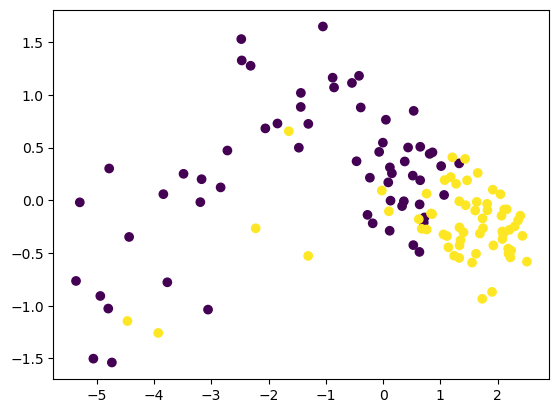

In [14]:
plt.scatter(Us[0], Us[1], c=YY)
plt.show()


In [7]:
c1 = pca.location(XX1)
XX1_c = XX1 - c1
As1, Ls1, Us1 = pca.find_pc_all(XX1_c, 10)

c2 = pca.location(XX2)
XX2_c = XX2 - c2
As2, Ls2, Us2 = pca.find_pc_all(XX2_c, 10)

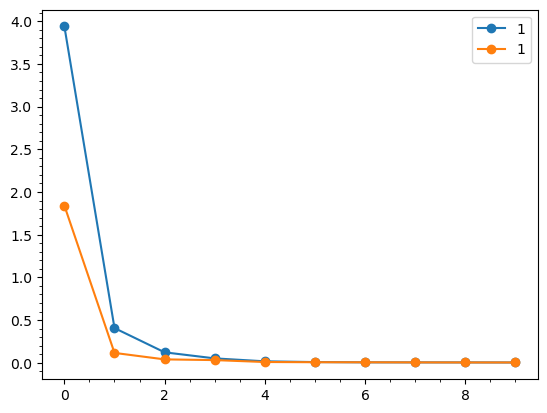

In [8]:
plt.plot(Ls1, marker='o', label='1')
plt.plot(Ls2, marker='o', label='1')
plt.minorticks_on()
plt.legend()
plt.show()

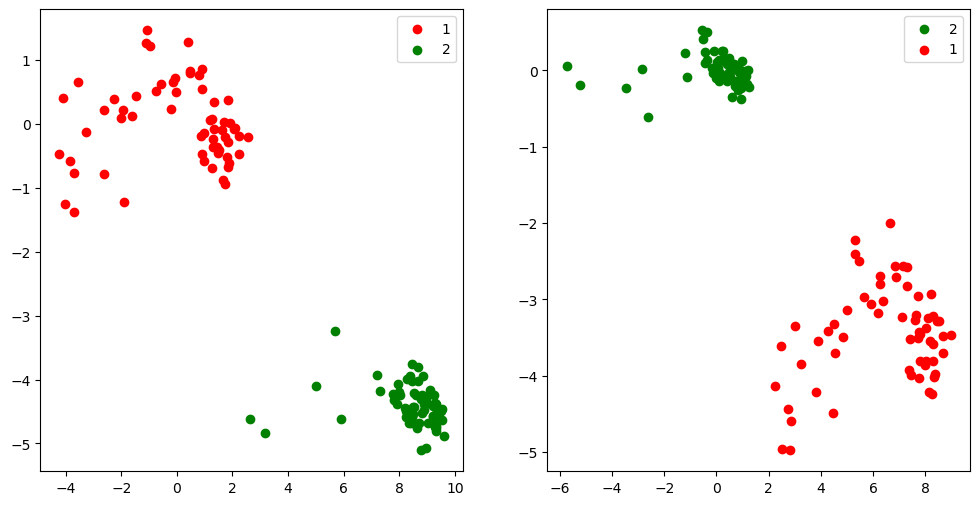

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Us1[0], Us1[1], c='r', label='1')
plt.scatter(XX2 @ As1[0], XX2 @ As1[1], c='g', label='2')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(Us2[0], Us2[2], c='g', label='2')
plt.scatter(XX1 @ As2[0], XX1 @ As2[1], c='r', label='1')
plt.legend()
plt.show()

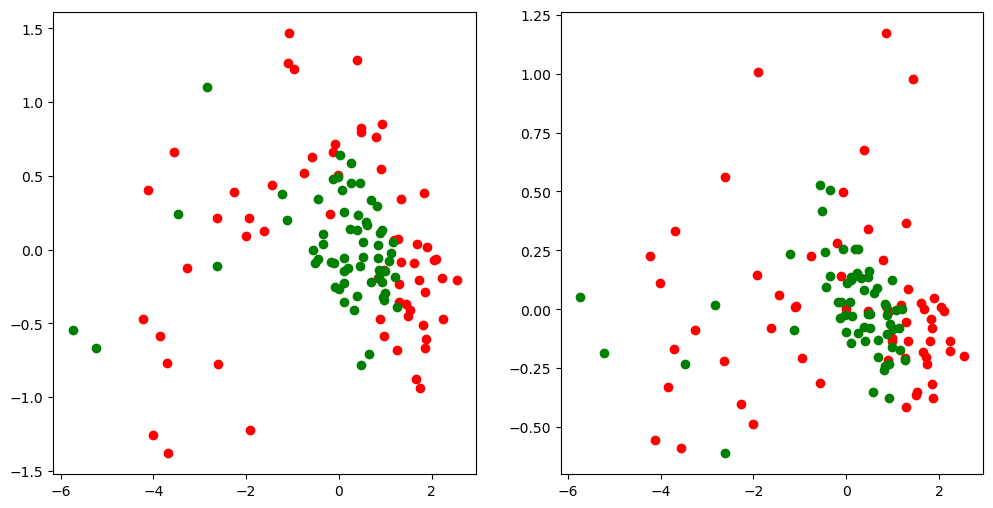

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Us1[0], Us1[1], c='r')
plt.scatter(Us2[0], Us2[1], c='g')
plt.subplot(1,2,2)
plt.scatter(Us1[0], Us1[2], c='r')
plt.scatter(Us2[0], Us2[2], c='g')
plt.show()

In [16]:
wma = af.averaging_function("WM", funcs.Quantile_Sqrt(0.9, 0.001))

In [17]:
c1 = pca.location_l1(XX1)
XX1_c1 = XX1 - c1

c2 = pca.location_l1(XX2)
XX2_c2 = XX2 - c2

In [18]:
As1, Ls1, Us1 = pca.find_pc_l1_all(XX1_c1, 3)

In [19]:
As2, Ls2, Us2 = pca.find_pc_l1_all(XX2_c2, 3)

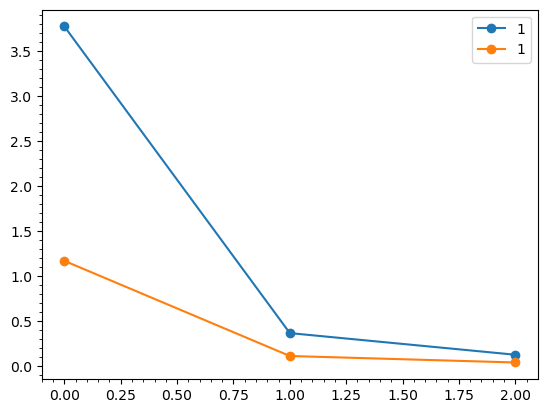

In [20]:
plt.plot(Ls1, marker='o', label='1')
plt.plot(Ls2, marker='o', label='1')
plt.minorticks_on()
plt.legend()
plt.show()

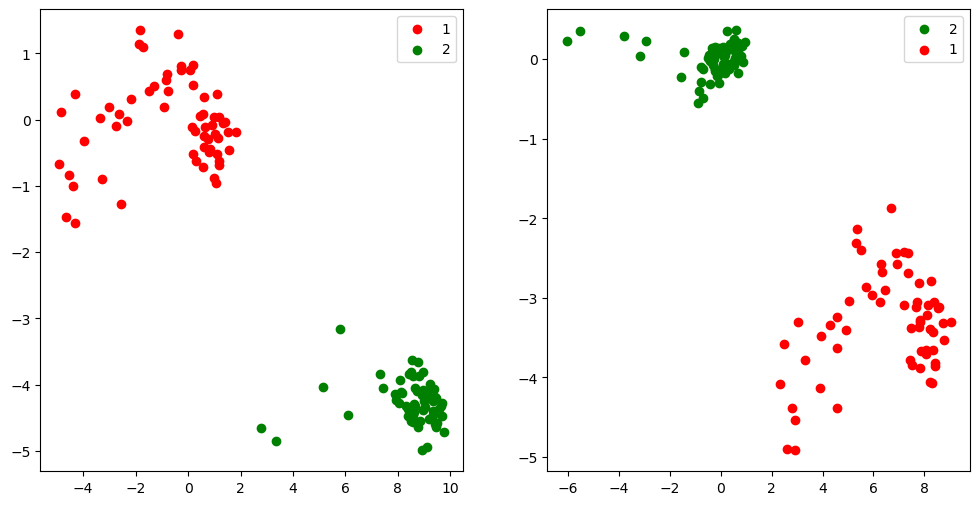

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Us1[0], Us1[1], c='r', label='1')
plt.scatter(XX2 @ As1[0], XX2 @ As1[1], c='g', label='2')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(Us2[0], Us2[2], c='g', label='2')
plt.scatter(XX1 @ As2[0], XX1 @ As2[1], c='r', label='1')
plt.legend()
plt.show()

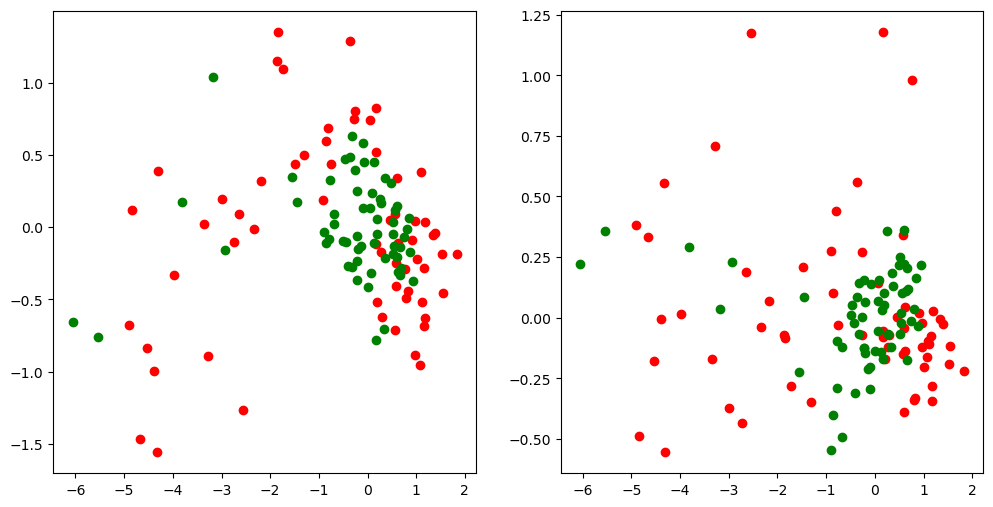

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Us1[0], Us1[1], c='r')
plt.scatter(Us2[0], Us2[1], c='g')
plt.subplot(1,2,2)
plt.scatter(Us1[0], Us1[2], c='r')
plt.scatter(Us2[0], Us2[2], c='g')
plt.show()